<a href="https://colab.research.google.com/github/Oloxor/FirstRepository/blob/main/ag2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-48-2daf1e6d9579>:124: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X1, X2, C1, levels=[0], colors='red', linewidths=2, linestyles='dashed', label='Ograniczenie 1: x1 * x2 <= -3')
<ipython-input-48-2daf1e6d9579>:125: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X1, X2, C2, levels=[0], colors='blue', linewidths=2, linestyles='dashed', label='Ograniczenie 2: x2 <= -3')


Najlepsze rozwiązanie: [-2.41063958  1.24464108]
Wartość funkcji celu: 0.522136743247924
Ograniczenie 1: -0.00038104861286258895
Ograniczenie 2: -0.06592023552965998


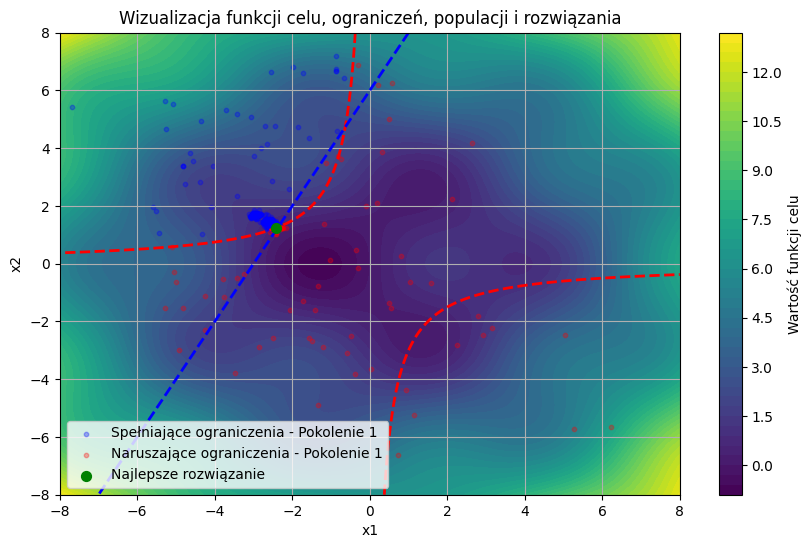

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Funkcja celu (sinusoidalna z dodatkowymi małymi minimami)
def objective_function(x):
    return np.sin(x[0]) * np.cos(x[1]) + 0.1 * (x[0]**2 + x[1]**2)

# Ograniczenia nieliniowe
def constraint_1(x):
    return x[0] * x[1] + 3  # Ograniczenie 1: x1 * x2 <= -3

def constraint_2(x):
    return -x[1] + 2 * x[0] + 6 # Ograniczenie 2

# Funkcja kary za naruszenie ograniczeń
def penalized_objective(x, penalty=1e6):
    penalty_value = 0
    if constraint_1(x) >= 0:
        penalty_value += penalty * constraint_1(x)
    if constraint_2(x) >= 0:
        penalty_value += penalty * constraint_2(x)
    return objective_function(x) + penalty_value

# Inicjalizacja populacji
def initialize_population(pop_size, bounds):
    return np.array([[np.random.uniform(bounds[i][0], bounds[i][1]) for i in range(len(bounds))] for _ in range(pop_size)])

# Selekcja turniejowa z uwzględnieniem funkcji kary
def selection(population, penalized_scores, k=3):
    selected_indices = np.random.choice(len(population), k, replace=False)
    return population[min(selected_indices, key=lambda i: penalized_scores[i])]

# Krzyżowanie (arytmetyczne)
def crossover(parent1, parent2):
    alpha = np.random.rand()
    return alpha * parent1 + (1 - alpha) * parent2

# Mutacja (Gaussian)
def mutate(individual, bounds, mutation_rate=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] += np.random.normal(0, 0.1)
            individual[i] = np.clip(individual[i], bounds[i][0], bounds[i][1])
    return individual

# Dwupopulacyjny algorytm ewolucyjny z migracją
def two_population_ea(objective_function, constraints, bounds, pop_size=50, generations=100):
    main_population = initialize_population(pop_size, bounds)
    auxiliary_population = initialize_population(pop_size, bounds)
    all_main_populations = []  # Lista do przechowywania każdej populacji głównej
    all_auxiliary_populations = []  # Lista do przechowywania każdej populacji pomocniczej

    for gen in range(generations):
        # Ocena populacji głównej z uwzględnieniem kary
        main_penalized_scores = np.array([penalized_objective(ind) for ind in main_population])
        main_constraints = np.array([[constraints[0](ind), constraints[1](ind)] for ind in main_population])

        # Ocena populacji pomocniczej z uwzględnieniem kary
        auxiliary_penalized_scores = np.array([penalized_objective(ind) for ind in auxiliary_population])
        auxiliary_constraints = np.array([[constraints[0](ind), constraints[1](ind)] for ind in auxiliary_population])

        # Tworzenie nowej populacji głównej
        new_main_population = []
        for _ in range(pop_size):
            parent1 = selection(main_population, main_penalized_scores)
            parent2 = selection(main_population, main_penalized_scores)
            child = crossover(parent1, parent2)
            child = mutate(child, bounds)
            new_main_population.append(child)
        main_population = np.array(new_main_population)

        # Tworzenie nowej populacji pomocniczej
        new_auxiliary_population = []
        for _ in range(pop_size):
            parent1 = selection(auxiliary_population, auxiliary_penalized_scores)
            parent2 = selection(auxiliary_population, auxiliary_penalized_scores)
            child = crossover(parent1, parent2)
            child = mutate(child, bounds)
            new_auxiliary_population.append(child)
        auxiliary_population = np.array(new_auxiliary_population)

        # Migracja najlepszych osobników
        feasible_main = [i for i in range(pop_size) if all(c <= 0 for c in main_constraints[i])]
        feasible_auxiliary = [i for i in range(pop_size) if all(c <= 0 for c in auxiliary_constraints[i])]

        if feasible_main and feasible_auxiliary:
            # Wybierz najlepsze osobniki z obu populacji
            best_main_index = min(feasible_main, key=lambda i: main_penalized_scores[i])
            best_auxiliary_index = min(feasible_auxiliary, key=lambda i: auxiliary_penalized_scores[i])

            # Zamiana osobników między populacjami
            main_population[np.argmax(main_penalized_scores)] = auxiliary_population[best_auxiliary_index]
            auxiliary_population[np.argmax(auxiliary_penalized_scores)] = main_population[best_main_index]

        # Przechowywanie populacji dla późniejszej wizualizacji
        all_main_populations.append(main_population.copy())
        all_auxiliary_populations.append(auxiliary_population.copy())

    return all_main_populations, all_auxiliary_populations

# Parametry
bounds = [(-8, 8), (-8, 8)]  # Zmienione zakresy x1 i x2
pop_size = 50
generations = 100

# Uruchomienie algorytmu
all_main_populations, all_auxiliary_populations = two_population_ea(objective_function, [constraint_1, constraint_2], bounds, pop_size, generations)


# Wizualizacja
x1 = np.linspace(bounds[0][0], bounds[0][1], 400)
x2 = np.linspace(bounds[1][0], bounds[1][1], 400)
X1, X2 = np.meshgrid(x1, x2)
Z = objective_function([X1, X2])  # Wartości funkcji celu
C1 = constraint_1([X1, X2])  # Wartości ograniczenia 1
C2 = constraint_2([X1, X2])  # Wartości ograniczenia 2

# Wykres funkcji celu
plt.figure(figsize=(10, 6))
plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
plt.colorbar(label='Wartość funkcji celu')

# Wykres ograniczeń
plt.contour(X1, X2, C1, levels=[0], colors='red', linewidths=2, linestyles='dashed', label='Ograniczenie 1: x1 * x2 <= -3')
plt.contour(X1, X2, C2, levels=[0], colors='blue', linewidths=2, linestyles='dashed', label='Ograniczenie 2: x2 <= -3')

# Wizualizacja populacji głównej i pomocniczej
for gen in range(0, generations, 10):  # Rysuj co 10-te pokolenie
    # Połączenie populacji głównej i pomocniczej
    combined_pop = np.vstack([all_main_populations[gen], all_auxiliary_populations[gen]])

    # Sprawdzamy, które osobniki spełniają oba ograniczenia
    feasible = [ind for ind in combined_pop if constraint_1(ind) <= 0 and constraint_2(ind) <= 0]
    infeasible = [ind for ind in combined_pop if constraint_1(ind) > 0 or constraint_2(ind) > 0]

    if feasible:
      best_solution = min(feasible, key=lambda x: objective_function(x))


    # Rysowanie kropki dla osobników spełniających i naruszających ograniczenia
    plt.scatter([ind[0] for ind in feasible], [ind[1] for ind in feasible], color='blue', s=10, alpha=0.3, label=f'Spełniające ograniczenia - Pokolenie {gen+1}' if gen == 0 else "")
    plt.scatter([ind[0] for ind in infeasible], [ind[1] for ind in infeasible], color='red', s=10, alpha=0.3, label=f'Naruszające ograniczenia - Pokolenie {gen+1}' if gen == 0 else "")

# Wykres najlepszego rozwiązania (jako zielona kropka)
plt.scatter(best_solution[0], best_solution[1], color='green', s=50, alpha=1, zorder=5, label='Najlepsze rozwiązanie')
print("Najlepsze rozwiązanie:", best_solution)
print("Wartość funkcji celu:", objective_function(best_solution))
print("Ograniczenie 1:", constraint_1(best_solution))
print("Ograniczenie 2:", constraint_2(best_solution))
# Dodanie opisów
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Wizualizacja funkcji celu, ograniczeń, populacji i rozwiązania')
plt.legend()
plt.grid(True)
plt.show()